In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../../../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)


In [ ]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) # number of citations (cbc = cited by count) of the works published a given year

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) # left join

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = group_year_mean.sort(by="year", descending=True)
group_references_mean = (
    works.lazy() 
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  
)

works

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

In [3]:
unique_counts = works.select("authors_count").unique().sort("authors_count").to_series().to_list() 
results = [] 
for ac in unique_counts: 
    chunk = works.filter(pl.col("authors_count") == ac) 
    mean_cited_by = chunk["cited_by_count"].mean() 
    mean_mncs = chunk["mncs"].mean() 
    results.append([ac, ac, mean_cited_by, mean_mncs]) 
    
    
group_Nauthors_mean = pl.DataFrame( results, schema=["by", "authors_count", "cited_by_count", "mncs"] ) 
results_low = [] 
for ac in unique_counts: 
    chunk = works.filter((pl.col("authors_count") == ac) & (pl.col("mncs") < 0.1)) 
    if len(chunk) == 0: 
        continue 
    mean_cited_by = chunk["cited_by_count"].mean() 
    mean_mncs = chunk["mncs"].mean() 
    results_low.append([ac, ac, mean_cited_by, mean_mncs]) 
    
group_Nauthors_mean_low_citations = pl.DataFrame( 
results_low, schema=["by", "authors_count", "cited_by_count", "mncs"] ) 
group_Nauthors_mean

C:\Users\noahr\AppData\Local\Temp\ipykernel_12156\2901082391.py:10: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  group_Nauthors_mean = pl.DataFrame( results, schema=["by", "authors_count", "cited_by_count", "mncs"] )
C:\Users\noahr\AppData\Local\Temp\ipykernel_12156\2901082391.py:20: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  group_Nauthors_mean_low_citations = pl.DataFrame(


by,authors_count,cited_by_count,mncs
i64,i64,f64,f64
0,0,0.701612,0.029746
1,1,35.905374,0.869802
2,2,47.788483,1.204872
3,3,45.41555,1.141463
4,4,44.010149,1.119471
…,…,…,…
96,96,8.0,0.24729
97,97,5.666667,0.827104
98,98,29.333333,2.010371


In [ ]:


import re

cols_authors = sorted([c for c in works.columns if re.match(r"author_\d+", c)])
cols_countries = sorted([c for c in works.columns if re.match(r"country_\d+", c)])

print(f"{len(cols_authors)} colonnes d'auteurs détectées")
print(f"{len(cols_countries)} colonnes de pays détectées")

base_cols = ["title", "year", "cited_by_count", "mncs"]
works_small = works.select(base_cols + cols_authors + cols_countries)

df_list = []

for i in range(len(cols_authors)):
    df_i = (
        works_small
        .select([
            *base_cols,
            pl.col(cols_authors[i]).alias("author"),
            pl.col(cols_countries[i]).alias("country")
        ])
        .with_columns(pos=pl.lit(i + 1))
        .filter(pl.col("author").is_not_null())
    )
    df_list.append(df_i)

authors = pl.concat(df_list)

authors = authors.with_columns(count=pl.lit(1, dtype=pl.Int8))

authors = authors.drop("title")

authors


100 colonnes d'auteurs détectées
270 colonnes de pays détectées


year,cited_by_count,mncs,author,country,pos,count
i64,i64,f64,str,str,i32,i8
2004,1881,35.103559,"""https://openalex.org/A50102407…","""US""",1,1
2010,1294,24.857588,"""https://openalex.org/A50909767…","""US""",1,1
2015,898,23.127161,"""https://openalex.org/A50341518…","""NL""",1,1
2008,786,14.902469,"""https://openalex.org/A50898992…","""US""",1,1
2001,722,12.263251,"""https://openalex.org/A50062088…","""US""",1,1
…,…,…,…,…,…,…
2023,10,0.970459,"""https://openalex.org/A50209839…",null,100,1
2017,0,0.0,"""https://openalex.org/A51030170…",null,100,1
2013,281,6.219137,"""https://openalex.org/A50193289…",null,100,1


In [5]:
missing_countries = authors.filter(pl.col("country").is_null()).height
total_authors = authors.height

print(f"Nombre d'auteurs sans pays : {missing_countries} sur {total_authors} ({missing_countries/total_authors*100:.2f}%)")

Nombre d'auteurs sans pays : 2594622 sur 3444050 (75.34%)


In [6]:
top_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "cited_by_count", descending=True)
    .drop(["index_work", "author_name"])
)

active_authors = (
    authors
    .group_by(by = "author_name")
    .sum()
    .sort(by = "count", descending=True)
    .drop(["index_work", "author_name"])
)

top_authors

ColumnNotFoundError: unable to find column "author_name"; valid columns: ["year", "cited_by_count", "mncs", "author", "country", "pos", "count"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["year", "cited_by_count", "mncs", "author", ...]; PROJECT */7 COLUMNS

In [ ]:
import pyalex as alex

top_10_authors = top_authors.head(20)

names = []
institutions = []
countries = []

for aid in top_10_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    author = alex.Authors()[aid]
    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

top_10_authors = top_10_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])

top_10_authors


by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""https://openalex.org/I24156275""","""BE"""
"""https://openalex.org/A50374811…",null,824163,37048,794.874141,null,410,"""Patrice Nordmann""","""https://openalex.org/I15433846…","""CH"""
"""https://openalex.org/A50053578…",null,232802,35917,974.427229,null,117,"""Salvador Moncada""","""https://openalex.org/I63634437""","""ES"""
"""https://openalex.org/A50807623…",null,660308,32728,745.182168,null,329,"""Trevor W. Robbins""","""https://openalex.org/I241749""","""GB"""
"""https://openalex.org/A50873190…",null,629484,30527,657.805362,null,313,"""Laurent Poirel""","""https://openalex.org/I15433846…","""CH"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50791971…",null,209097,24665,543.587878,null,104,"""Johan W.S. Vlaeyen""","""https://openalex.org/I34352273""","""NL"""
"""https://openalex.org/A50904197…",null,538506,24471,757.397758,null,268,"""S P H Alexander""","""https://openalex.org/I14226353…","""GB"""
"""https://openalex.org/A50660947…",null,274813,23098,515.933998,null,137,"""Troels S. Jensen""","""https://openalex.org/I42101460…","""DK"""


In [ ]:
top_10_authors

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""https://openalex.org/I24156275""","""BE"""
"""https://openalex.org/A50374811…",null,824163,37048,794.874141,null,410,"""Patrice Nordmann""","""https://openalex.org/I15433846…","""CH"""
"""https://openalex.org/A50053578…",null,232802,35917,974.427229,null,117,"""Salvador Moncada""","""https://openalex.org/I63634437""","""ES"""
"""https://openalex.org/A50807623…",null,660308,32728,745.182168,null,329,"""Trevor W. Robbins""","""https://openalex.org/I241749""","""GB"""
"""https://openalex.org/A50873190…",null,629484,30527,657.805362,null,313,"""Laurent Poirel""","""https://openalex.org/I15433846…","""CH"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50791971…",null,209097,24665,543.587878,null,104,"""Johan W.S. Vlaeyen""","""https://openalex.org/I34352273""","""NL"""
"""https://openalex.org/A50904197…",null,538506,24471,757.397758,null,268,"""S P H Alexander""","""https://openalex.org/I14226353…","""GB"""
"""https://openalex.org/A50660947…",null,274813,23098,515.933998,null,137,"""Troels S. Jensen""","""https://openalex.org/I42101460…","""DK"""


In [ ]:
authors = authors.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("author_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("author_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("author_name") - pl.col("mncs")).alias("cumulative_mncs")
])

authors = authors.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_authors")
)
test = authors.filter(pl.col("author_name") == "https://openalex.org/A5080551159")
test

title,year,index_work,cited_by_count,mncs,author_pos,author_name,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,u32,i64,f64,str,str,i8,i64,i64,f64,f64
"""quantitative studies on the ga…",1910,44,1,0.262032,"""author_1""","""https://openalex.org/A50805511…",1,0,0,0.0,1.0
"""the actions of caffein on the …",1911,80,21,6.943548,"""author_1""","""https://openalex.org/A50805511…",1,1,1,0.262032,0.262032
"""the actions of caffein on the …",1911,113,0,0.0,"""author_1""","""https://openalex.org/A50805511…",1,2,22,7.20558,3.60279
"""alcohol and caffein: a study o…",1912,127,11,1.941176,"""author_2""","""https://openalex.org/A50805511…",1,3,22,7.20558,2.40186
"""quantitative studies of vagus …",1914,236,3,0.15894,"""author_2""","""https://openalex.org/A50805511…",1,4,33,9.146757,2.286689
…,…,…,…,…,…,…,…,…,…,…,…
"""reactions of carotid arteries …",1938,3085,1,0.173714,"""author_1""","""https://openalex.org/A50805511…",1,68,310,74.241247,1.091783
"""the pharmacology of trimethyl …",1939,3158,18,2.666667,"""author_1""","""https://openalex.org/A50805511…",1,69,311,74.414961,1.078478
"""pharmacologic responses of dap…",1941,3508,8,0.317403,"""author_1""","""https://openalex.org/A50805511…",1,70,329,77.081628,1.101166


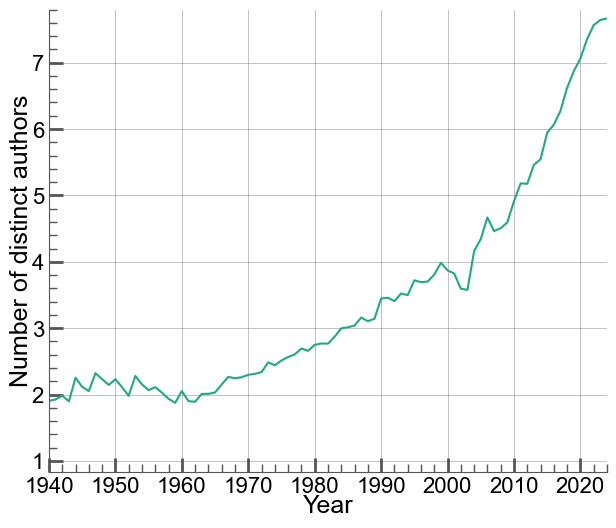

Mean authors count: 2.8519224266961754
Median authors count: 2.2640243403120333


<Figure size 640x480 with 0 Axes>

In [ ]:
years = group_year_mean["year"].to_list()
authors_counts = group_year_mean["authors_count"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.plot(years, authors_counts, color=plt.cm.viridis(0.6))  
    plt.xlabel("Year", fontsize=18)
    plt.ylabel("Number of distinct authors", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(1940, 2024)
    plt.show()
    
mean_value = group_year_mean.select(pl.col("authors_count").mean())[0, 0]
median_value = group_year_mean.select(pl.col("authors_count").median())[0, 0]

print(f"Mean authors count: {mean_value}")
print(f"Median authors count: {median_value}")

In [ ]:
r_pearson, p_pearson = st.pearsonr(works["authors_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["authors_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.045, p-value = 0.000
Spearman: rho = 0.279, p-value = 0.000


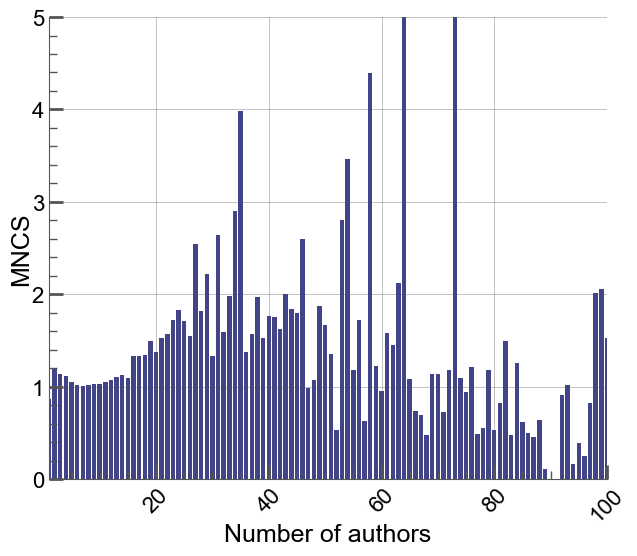

In [ ]:
authors_count = group_Nauthors_mean["authors_count"].to_list()
mncs = group_Nauthors_mean["mncs"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.bar(authors_count, mncs, color=plt.cm.viridis(0.2)) 
    plt.xlim(1, 100)
    plt.ylim(0, 5)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of authors", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

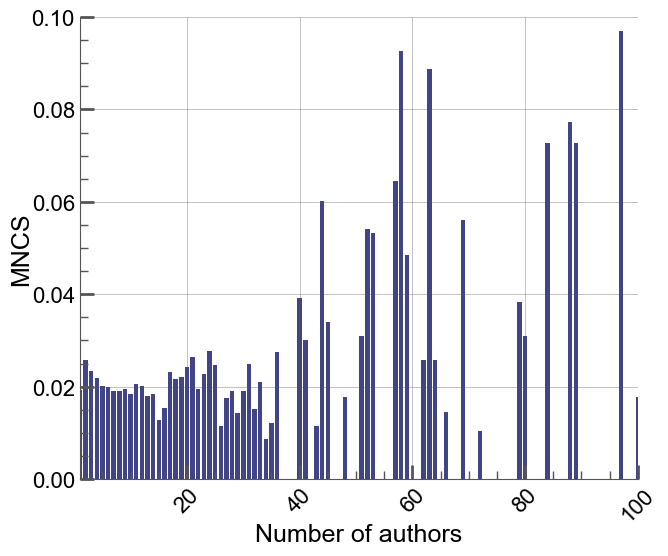

In [ ]:
authors_count = group_Nauthors_mean_low_citations["authors_count"].to_list()
mncs = group_Nauthors_mean_low_citations["mncs"].to_list()

with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    plt.bar(authors_count, mncs, color=plt.cm.viridis(0.2))  
    plt.xlim(1, 100)
    plt.ylim(0, 0.1)
    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Number of authors", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


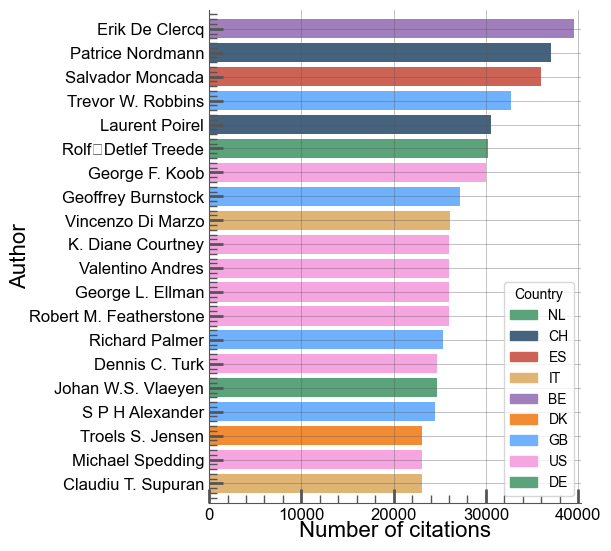

In [ ]:
palette = ["#5aa37b", "#45637d", "#cc6355", "#e0b474", "#a17fbd", "#f28c34", "#6fb1fc", "#f5a6e1"]

names = top_10_authors["name"].to_list()
citations = top_10_authors["cited_by_count"].to_list()
countries = top_10_authors["country"].to_list()

unique_countries = list(set(countries))
country_colors = {country: palette[i % len(palette)] for i, country in enumerate(unique_countries)}
colors = [country_colors[c] for c in countries]

names = names[::-1]
citations = citations[::-1]
colors = colors[::-1]

with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8, 6.4))
    plt.barh(names, citations, color=colors)
    plt.xlabel("Number of citations", fontsize=16)
    plt.ylabel("Author", fontsize=16)

    handles = [plt.Rectangle((0,0),1,1, color=country_colors[c]) for c in unique_countries]
    plt.legend(handles, unique_countries, title="Country")

    plt.show()

C:\Users\noahr\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


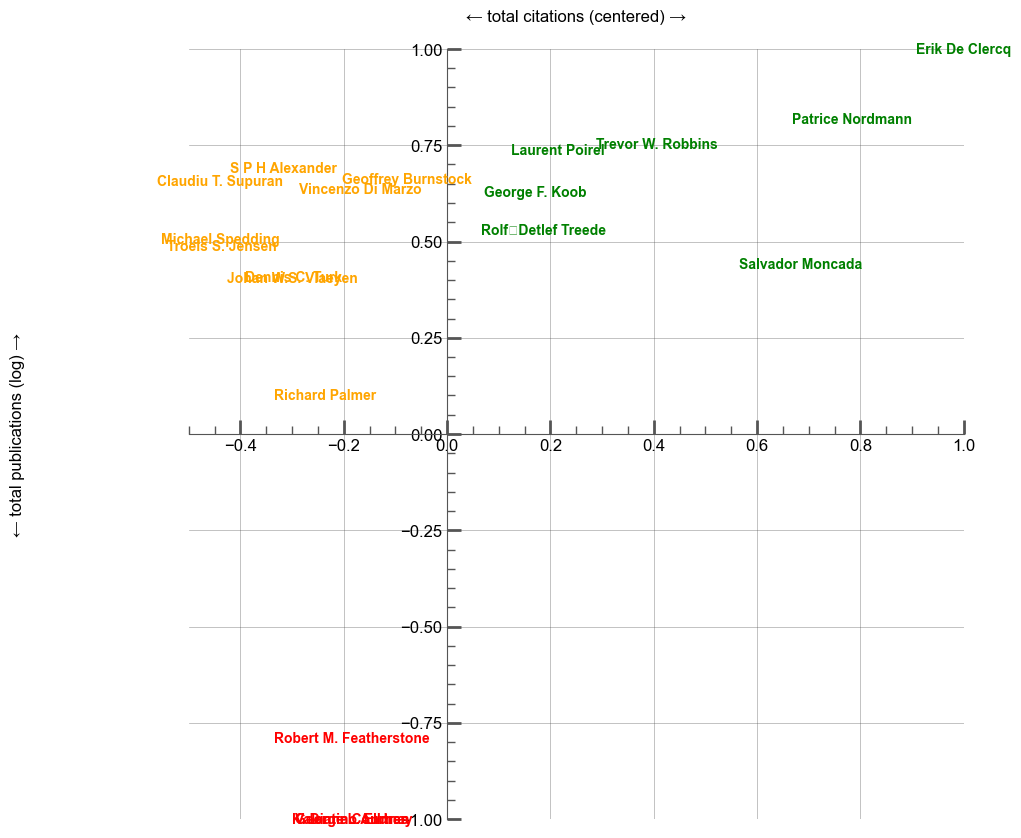

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# --- Préparer les coordonnées pour le plot ---
top_10_authors = top_10_authors.with_columns([
    pl.col("count").log().alias("publications_log"),  # log des publications
])

mean_cit = top_10_authors["cited_by_count"].mean()
top_10_authors = top_10_authors.with_columns(
    (pl.col("cited_by_count") - mean_cit).alias("citations_centered")  # citations centrées
)

pub_log = top_10_authors["publications_log"].to_numpy()
y_min = np.min(pub_log)
y_max = np.max(pub_log)

citations = top_10_authors["cited_by_count"].to_numpy()
cit_mean = np.mean(citations)
cit_max_abs = np.max(np.abs(citations - cit_mean))

top_10_authors = top_10_authors.with_columns([
    ((pl.col("publications_log") - y_min) / (y_max - y_min) * 2 - 1).alias("y_viz"),
    ((pl.col("cited_by_count") - cit_mean) / cit_max_abs).alias("x_viz")
])
# --- Plot ---
plt.figure(figsize=(10, 10))
for name, x, y in zip(
    top_10_authors["name"],
    top_10_authors["x_viz"],
    top_10_authors["y_viz"]
):
    if y >= 0 and x >= 0:
        color = "green"
    elif y >= 0 and x < 0:
        color = "orange"
    elif y < 0 and x < 0:
        color = "red"
    else:
        color = "purple"
    plt.text(x, y, name, ha="center", va="center", fontsize=10, fontweight="bold", color=color)

plt.xlabel("← total citations (centered) →", labelpad=-320)
plt.ylabel("← total publications (log) →", labelpad=270)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

plt.show()


In [ ]:
authors

title,year,index_work,cited_by_count,mncs,author_pos,author_name,count,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_authors
str,i64,u32,i64,f64,str,str,i8,i64,i64,f64,f64
"""on the pharmacological action …",1909,0,47,10.143885,"""author_1""","""https://openalex.org/A51102708…",1,0,0,0.0,1.0
"""on the pharmacological action …",1909,0,47,10.143885,"""author_2""","""https://openalex.org/A50329477…",1,0,0,0.0,1.0
"""the antagonism of the adrenal …",1909,1,15,3.23741,"""author_1""","""https://openalex.org/A51116416…",1,0,0,0.0,1.0
"""quantitative experiments with …",1909,2,14,3.021583,"""author_1""","""https://openalex.org/A50125106…",1,0,0,0.0,1.0
"""the comparative toxicity of th…",1909,3,12,2.589928,"""author_1""","""https://openalex.org/A51121624…",1,0,0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
"""anti-hbs positivity related to…",2024,689359,0,0.0,"""author_6""","""https://openalex.org/A50096987…",1,0,0,0.0,1.0
"""anti-hbs positivity related to…",2024,689359,0,0.0,"""author_7""","""https://openalex.org/A50455171…",1,0,0,0.0,1.0
"""antigen delivery platforms for…",2024,689360,0,0.0,"""author_1""","""https://openalex.org/A50109076…",1,2,64,1.260381,0.630191


In [ ]:
import pyalex as alex

top_100_authors = top_authors.head(100)

names = []
institutions = []
countries = []

for aid in top_100_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    author = alex.Authors()[aid]
    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

top_100_authors = top_100_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])

top_100_authors

KeyboardInterrupt: 

In [ ]:
first_names = []

for n in top_100_authors["name"]:
    if isinstance(n, str):
        first_author = n.split("&")[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    elif isinstance(n, list) and len(n) > 0:
        first_author = n[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    else:
        first_names.append(None)



C:\Users\noahr\AppData\Local\Temp\ipykernel_17144\2438585306.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","pink","lightgray"])


<Figure size 640x480 with 0 Axes>

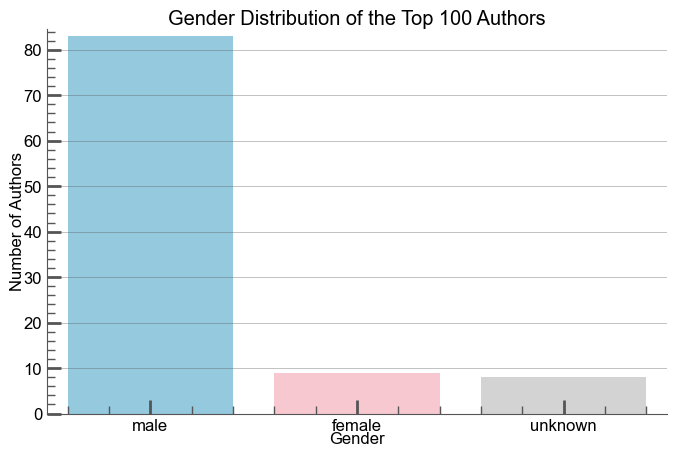

In [ ]:
import gender_guesser.detector as gender

d = gender.Detector()

def normalize_gender(g):
    if g in ["male","mostly_male"]:
        return "male"
    elif g in ["female","mostly_female"]:
        return "female"
    else:
        return "unknown"

gender_map_list = [(name, normalize_gender(d.get_gender(name))) for name in first_names]

df_gender = pd.DataFrame(gender_map_list, columns=["first_name", "gender"])

gender_counts = df_gender["gender"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","pink","lightgray"])
plt.title("Gender Distribution of the Top 100 Authors (Citations)")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.show()

In [ ]:
active_100_authors = active_authors.head(100)

names = []
institutions = []
countries = []

for aid in active_100_authors["by"].to_list():
    if not isinstance(aid, str):
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    try:
        author = alex.Authors()[aid]
    except Exception as e:
        names.append(None)
        institutions.append(None)
        countries.append(None)
        continue

    names.append(author.get("display_name"))

    inst_list = author.get("affiliations") or []
    if len(inst_list) > 0:
        inst_id = inst_list[0]["institution"].get("id")
        if isinstance(inst_id, str):
            institutions.append(inst_id)
            try:
                countries.append(alex.Institutions()[inst_id].get("country_code"))
            except Exception:
                countries.append(None)
        else:
            institutions.append(None)
            countries.append(None)
    else:
        institutions.append(None)
        countries.append(None)

active_100_authors = active_100_authors.with_columns([
    pl.Series("name", names),
    pl.Series("institution", institutions),
    pl.Series("country", countries)
])


active_100_authors

by,title,year,cited_by_count,mncs,author_pos,count,name,institution,country
str,str,i64,i64,f64,str,i64,str,str,str
"""https://openalex.org/A99999999…",null,1558668,3691,103.164803,null,784,null,null,null
"""https://openalex.org/A50406623…",null,1495708,39523,972.942793,null,748,"""Erik De Clercq""","""https://openalex.org/I24156275""","""BE"""
"""https://openalex.org/A50201253…",null,1402441,1270,40.985707,null,695,"""Sarah Crunkhorn""","""https://openalex.org/I25705611…","""GB"""
"""https://openalex.org/A50188815…",null,1219279,10374,429.945174,null,604,"""Asher Mullard""","""https://openalex.org/I42100996…","""CA"""
"""https://openalex.org/A50458774…",null,955705,7732,180.894305,null,476,"""Siegfried Kasper""","""https://openalex.org/I76134821""","""AT"""
…,…,…,…,…,…,…,…,…,…
"""https://openalex.org/A50137915…",null,323313,19969,572.660734,null,162,"""Edward M. Sellers""","""https://openalex.org/I18526175…","""CA"""
"""https://openalex.org/A50910885…",null,326678,3735,90.536893,null,162,"""Marcella Rietschel""","""https://openalex.org/I22382290…","""DE"""
"""https://openalex.org/A50730463…",null,325263,12384,278.829047,null,162,"""Roger L. Nation""","""https://openalex.org/I56590836""","""AU"""


In [ ]:
first_names = []

for n in active_100_authors["name"]:
    if isinstance(n, str):
        first_author = n.split("&")[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    elif isinstance(n, list) and len(n) > 0:
        first_author = n[0].strip()
        first_name = first_author.split()[0].strip()
        first_names.append(first_name)
    else:
        first_names.append(None)



C:\Users\noahr\AppData\Local\Temp\ipykernel_17144\3960205808.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","pink","lightgray"])


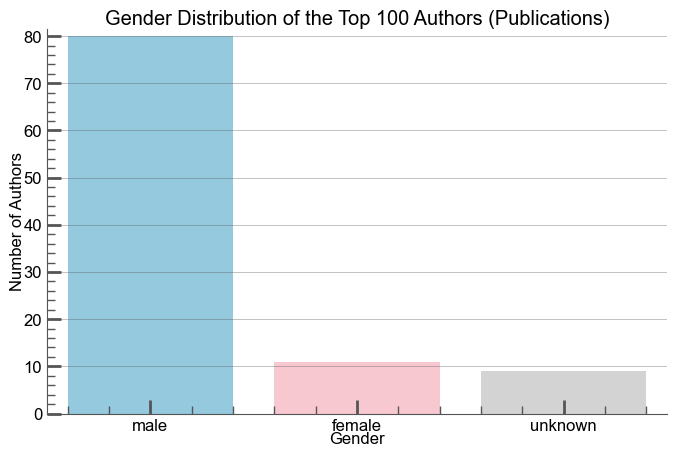

In [ ]:


d = gender.Detector()

# 2️⃣ Fonction de normalisation
def normalize_gender(g):
    if g in ["male","mostly_male"]:
        return "male"
    elif g in ["female","mostly_female"]:
        return "female"
    else:
        return "unknown"

gender_map_list = [(name, normalize_gender(d.get_gender(name))) for name in first_names]

df_gender = pd.DataFrame(gender_map_list, columns=["first_name", "gender"])

gender_counts = df_gender["gender"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=["skyblue","pink","lightgray"])
plt.title("Gender Distribution of the Top 100 Authors (Publications)")
plt.xlabel("Gender")
plt.ylabel("Number of Authors")
plt.show()